
### Drobpox file storage

In [56]:
def load_dropbox_token():
    '''
    Should explicitly add dropbox.token into the project
    because .gitignore exclude those files from github
    '''
    with open('dropbox.token', 'r') as token:
        dbx_token = token.read()
    return dbx_token[:len(dbx_token)-1]

TOKEN=load_dropbox_token()

PICTURE_REPOSITORY='projects/python/nbody-example-generator/images'
import dropbox, os, sys
from dropbox.files import WriteMode
from dropbox.exceptions import ApiError, AuthError
def exists_on_dbx(dbx, path):
    try:
        dbx.files_get_metadata(path)
        return True
    except:
        return False
    
def yesno(message, default=False, force=False):
    """Handy helper function to ask a yes/no question.
    Command line arguments --yes or --no force the answer;
    --default to force the default answer.
    Otherwise a blank line returns the default, and answering
    y/yes or n/no returns True or False.
    Retry on unrecognized answer.
    Special answers:
    - q or quit exits the program
    - p or pdb invokes the debugger
    """
    if force:
        return True
    
    if default:
        message += '? [Y/n] '
    else:
        message += '? [N/y] '
    
    while True:
        answer = raw_input(message).strip().lower()
        if not answer:
            return default
        if answer in ('y', 'yes'):
            return True
        if answer in ('n', 'no'):
            return False
        if answer in ('q', 'quit'):
            print('Exit')
            raise SystemExit(0)
        if answer in ('p', 'pdb'):
            import pdb
            pdb.set_trace()
        print('Please answer YES or NO.')
    
def sync(dbx, folder, BACKUPPATH='/backup/', ask_permission=True):
    import os
    files = filter(lambda f: f not in ['.', '..'], os.listdir(folder))
    for f in files:
        backup(dbx, os.path.join(folder, f), force=(not ask_permission))
    
# Uploads contents of LOCALFILE to Dropbox
def backup(dbx, LOCALFILE, BACKUPPATH='/backup/', force=False):
    BACKUPPATH=os.path.join(BACKUPPATH,LOCALFILE)
    with open(LOCALFILE, 'rb') as f:
        # We use WriteMode=overwrite to make sure that the settings in the file
        # are changed on upload
        if exists_on_dbx(dbx, BACKUPPATH):
            if not yesno("Are you sure you want to overwrite %s"%BACKUPPATH, force=force):
                return False
        print("Uploading " + LOCALFILE + " to Dropbox as " + BACKUPPATH + "...")    
        try:
            dbx.files_upload(f.read(), BACKUPPATH, mode=WriteMode('overwrite'))
        except ApiError as err:
            # This checks for the specific error where a user doesn't have
            # enough Dropbox space quota to upload this file
            if (err.error.is_path() and
                    err.error.get_path().error.is_insufficient_space()):
                sys.exit("ERROR: Cannot back up; insufficient space.")
            elif err.user_message_text:
                print(err.user_message_text)
                sys.exit()
            else:
                print(err)
                sys.exit()
dbx = dropbox.Dropbox(TOKEN)
try:
    dbx.users_get_current_account()
except AuthError as err:
    sys.exit("ERROR: Invalid access token; try re-generating an "
        "access token from the app console on the web.")


In [50]:
%matplotlib inline
import numpy
import itertools
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from pprint import pprint
from math import sqrt
cutoff=2.5*10**-2

def points_to_adjlist(x,y, cutoff_radius):
    adjlist = []
    for i in range(len(x)):
        part_interactions = [0] * len(x)
        for j in range(0, len(x)):
            if particle_distance( (x[i], y[i]), (x[j], y[j]) ) <= cutoff_radius:
                part_interactions[j] = 1
        adjlist.append(part_interactions)
    return adjlist

def points_to_edgelist(x, y, cutoff_radius):
    edgelist = []
    for i in range(len(x)):
        for j in range(i+1, len(x)):
            if particle_distance( (x[i], y[i]), (x[j], y[j]) ) <= cutoff_radius:
                edgelist.append((i, j))
    return edgelist

def points_to_graph(x, y, cutoff_radius):
    import networkx as nx
    G = nx.Graph()
    points = zip(x,y)
    for i in range(len(points)):
        G.add_node(i, position=points[i])
    for i in range(len(x)):
        for j in range(i+1, len(x)):
            if particle_distance( (x[i], y[i]), (x[j], y[j]) ) <= cutoff_radius:
                G.add_edge(i, j)
    return G    

def particle_distance(p1, p2):
    return sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def plot_particles(x, y, **kwargs):
    fig = kwargs.get('fig', plt.figure())
    cutoff = kwargs.get('cutoff_radius', 2.5*10**-2)
    if kwargs.get('interaction', True)==True:
        for i in range(len(x)):
            for j in range(i, len(x)):
                if particle_distance( (x[i], y[i]), (x[j], y[j]) ) <= cutoff:
                    plt.plot([x[i],x[j]], [y[i],y[j]], c='black', linestyle='--', linewidth=0.1)
    
    colors = kwargs.get('colors', {i: 'red' for i in range(len(x))})
    
    for xv,yv,cl in zip(x,y,colors.values()):
        plt.scatter(x=xv, y=yv, c=cl, s=5)
    
    if kwargs.get('cutoff', True) == True:
        numpy.random.seed()
        show_cutoff_particle = kwargs.get('cutoffid',int(numpy.random.uniform(0, 20)))
        plt.text(x[show_cutoff_particle]+cutoff, y[show_cutoff_particle]-cutoff, 'cut off')
        circ = plt.Circle((x[show_cutoff_particle], y[show_cutoff_particle]), radius=cutoff, color='g', linestyle='--', fill=False)
        ax = fig.add_subplot(1, 1, 1)
        ax.add_patch(circ)
        
    plt.axis('equal')
    plt.title('Simulation space')
    plt.xlabel('Particle position x')
    plt.ylabel('Particle position y')
    
    if kwargs.get('save', False):
        pp = PdfPages(kwargs.get('name'))
        pp.savefig()
        pp.close()


# Uniform distribution of 500 particles in a 1-by-1 space
Create a picture of 500 particles uniformly distributed in space
and interacting via a short range interaction (e.g., Lennard-Jones interactions)


KeyboardInterrupt: 

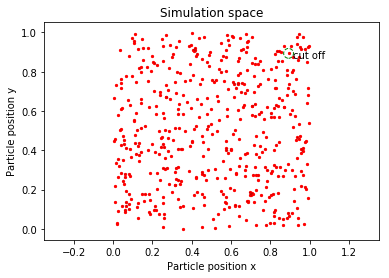

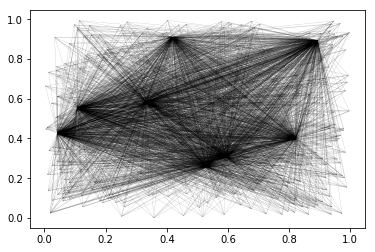

In [168]:
domain = [0,1]
numpy.random.seed(6)
uniform = lambda p,x :numpy.random.uniform(p, x)

nb = 500

x = [uniform(0.0, 1.0) for _ in range(nb)]
y = [uniform(0.0, 1.0) for _ in range(nb)]

plot_particles(x,y, interaction=True, cutoff=True, save=True, name='example_shortrange-nbody_uniform.pdf')

plot_particles(x,y, interaction=True, cutoff=True, cutoff_radius=1000, save=True, name='example_longrange-nbody_uniform.pdf')



## Non-uniform particle distribution in a 1-by-1 space
Non-uniform distribution (i.e., four gaussian (x&y) distributions), 
the interactions are illustrated by dashed lines and the cutoff radius is highlighted in green. 

Total number of particle generated:  300


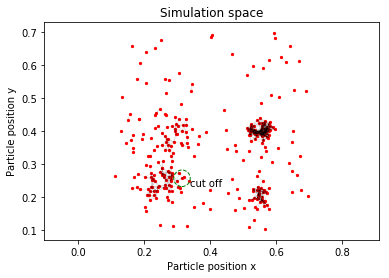

In [171]:
domain = [0,1]
numpy.random.seed(6)
normal = lambda p,x :numpy.random.normal(p, x)

uni = lambda: int(numpy.random.uniform(30,70))

nb = uni()
x = [normal(0.25, 0.035) for _ in range(nb)]
y = [normal(0.25, 0.035) for _ in range(nb)]

nb = uni()
x.extend([normal(0.55, 0.02) for _ in range(nb)])
y.extend([normal(0.2, 0.025) for _ in range(nb)])

nb = uni()
x.extend([normal(0.55, 0.02) for _ in range(nb)])
y.extend([normal(0.4, 0.02) for _ in range(nb)])

nb = uni()
x.extend([normal(0.28, 0.04) for _ in range(nb)])
y.extend([normal(0.4, 0.04) for _ in range(nb)])

rest = 300-len(x)
x.extend([uniform(0.1, 0.7) for _ in range(rest)])
y.extend([uniform(0.1, 0.7) for _ in range(rest)])

plot_particles(x,y, interaction=True, cutoff=True, save=True, name='example_nbody_non_uniform.pdf')

print 'Total number of particle generated: ', len(x)


Total number of particle generated:  500


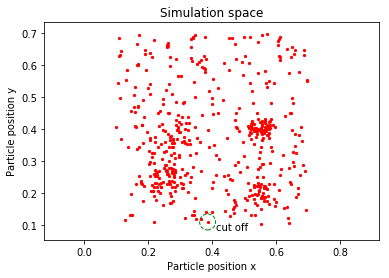

In [11]:
domain = [0,1]
numpy.random.seed(6)

normal = lambda p,x :numpy.random.normal(p, x)
uniform= lambda p,x :numpy.random.uniform(p, x)

uni = lambda: int(numpy.random.uniform(30,70))

nb = uni()
x = [normal(0.25, 0.035) for _ in range(nb)]
y = [normal(0.25, 0.035) for _ in range(nb)]

nb = uni()
x.extend([normal(0.55, 0.02) for _ in range(nb)])
y.extend([normal(0.2, 0.025) for _ in range(nb)])

nb = uni()
x.extend([normal(0.55, 0.02) for _ in range(nb)])
y.extend([normal(0.4, 0.02) for _ in range(nb)])

nb = uni()
x.extend([normal(0.28, 0.04) for _ in range(nb)])
y.extend([normal(0.4, 0.04) for _ in range(nb)])

rest = 500-len(x)
x.extend([uniform(0.1, 0.7) for _ in range(rest)])
y.extend([uniform(0.1, 0.7) for _ in range(rest)])

plot_particles(x,y, interaction=False, cutoff=True, cutoffid=300, save=True, name='example_nbody_non_uniform_clean.pdf')

print 'Total number of particle generated: ', len(x)

Total number of particle generated:  200


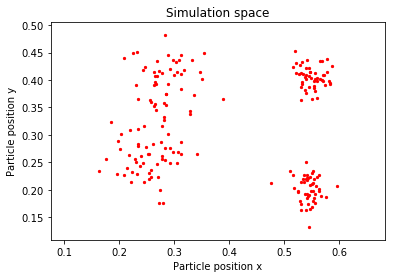

In [284]:
domain = [0,1]
numpy.random.seed(6)

normal = lambda p,x :numpy.random.normal(p, x)
uniform= lambda p,x :numpy.random.uniform(p, x)

uni = lambda: 50#int(numpy.random.uniform(30,70))

nb = uni()
x = [normal(0.25, 0.035) for _ in range(nb)]
y = [normal(0.25, 0.035) for _ in range(nb)]

nb = uni()
x.extend([normal(0.55, 0.02) for _ in range(nb)])
y.extend([normal(0.2, 0.025) for _ in range(nb)])

nb = uni()
x.extend([normal(0.55, 0.02) for _ in range(nb)])
y.extend([normal(0.4, 0.02) for _ in range(nb)])

nb = uni()
x.extend([normal(0.28, 0.04) for _ in range(nb)])
y.extend([normal(0.4, 0.04) for _ in range(nb)])

rest = 500-len(x)
#x.extend([uniform(0.1, 0.7) for _ in range(rest)])
#y.extend([uniform(0.1, 0.7) for _ in range(rest)])

plot_particles(x,y, interaction=False, cutoff=False, cutoffid=300, save=True, name='example_nbody_non_uniform_clean_RCB.pdf')

print 'Total number of particle generated: ', len(x)

### Recursive Coordinate Bisection Algorithm

In [187]:
def get_median(A, i):
    #divide A into sublists of len 5
    sublists = [A[j:j+5] for j in range(0, len(A), 5)]
    medians = [sorted(sublist)[len(sublist)/2] for sublist in sublists]
    if len(medians) <= 5:
        pivot = sorted(medians)[len(medians)/2]
    else:
        #the pivot is the median of the medians
        pivot = median_of_medians(medians, len(medians)/2)

    #partitioning step
    low = [j for j in A if j < pivot]
    high = [j for j in A if j > pivot]

    k = len(low)
    if i < k:
        return median_of_medians(low,i)
    elif i > k:
        return median_of_medians(high,i-k-1)
    else: #pivot = k
        return pivot

def get_median_with_index(data):
    sorted(data)[len(data)/2]
    
from math import log
log2 = lambda v: log(v)/log(2)

def RCB2D(x, y, part):
    points = zip(x,y)
    
    def bisect(points, dim):
        points.sort(key=lambda el: el[dim])
        median = points[int(len(points)/2)]
        idx_median = int(len(points)/2)
        b1, b2 = (points[:idx_median], points[idx_median:])
        return (median, idx_median, b1, b2)      
    
    d = [points] #start from full domain
    info = []
    for depth in range(int(log2(part))): #for each depth/dim
        dim = (depth) % 2 #dim = x first then y then x ...
        v = [bisect(section, dim) for section in d] #for each subsection...
        d = []
        for i in v:
            d.extend([i[2], i[3]])
        info.extend(v)
    return info #cutting list

In [ ]:
nbPE = 4
p2 = [2**i for i in range(int(log2(nbPE)))]

parent = lambda i: int((i-1)/2)
left   = lambda i: int(2*i + 1)
right  = lambda i: int(2*i + 2)

elem_at_dim = lambda dim: 2**(dim)
which_depth = lambda idx: int(log2(idx+1)) 
which_dim   = lambda idx: which_depth(idx) % 2

def get_cut_start_end_pos(parent_cut, size, parent_dim, left):
    if left==True:
        return (0, parent_cut[parent_dim])
    else:
        return (parent_cut[parent_dim], size)

def plot_cut(where, start_end, dim):
    if dim == 0:
        plt.plot([where, where], [start_end[0], start_end[1]], c='b', linestyle='--', linewidth=0.5)
    else:
        plt.plot([start_end[0], start_end[1]], [where, where], c='b', linestyle='--', linewidth=0.5)

def plotRCB(l, part_info, domain_max):
    ldim = which_depth(l) % 2
    if l == 0:
        se = get_cut_start_end_pos((0,0), domain_max, 0, False)
    else:
        se = get_cut_start_end_pos(part_info[parent(l)][0], domain_max, which_dim(parent(l)), True if l == left(parent(l)) else False)
    linfo = part_info[l]
    
    plot_cut(linfo[0][ldim], se, ldim)
    g = left(l)
    d = right(l)
    if g < len(part_info):
        plot(g, part_info, domain_max)
    if d < len(part_info):
        plot(d, part_info, domain_max)
        
nparticles = 1000
x = [normal(0.25, 0.035) for _ in range(nparticles)]
y = [normal(0.25, 0.035) for _ in range(nparticles)]

part_info = RCB2D(x, y, nbPE)
root = part_info[0]
n = 0
domain = 9

plot_particles(x,y, interaction=False, fig=fig, cutoff=False, save=False, name='example_nbody_non_uniform_clean_RCB.pdf')
plotRCB(0, part_info, max(max(x), max(y)))


### KMeans Clustering

[0 3 1 0 2 3 1 3 2 2 0 1 0 2 2 1 3 0 3 3 2 1 2 3 2]


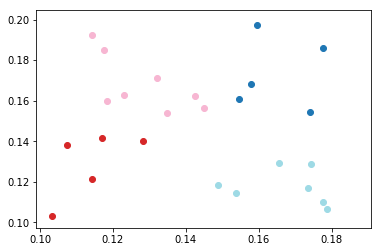

In [128]:
from sklearn.cluster import KMeans

nb_cluster = 4
kmeans = KMeans(n_clusters=nb_cluster)

X= zip(x,y)

cluster = kmeans.fit_predict(X)
cmap = get_cmap(nb_cluster, 'tab20')

for p in zip(X, cluster):
    plt.scatter(p[0][0], p[0][1], c=cmap(p[1]))

labels = kmeans.labels_

print labels

### METIS Graph Partitioning

Are you sure you want to overwrite /backup/images/example_graph_part_metis_colored_without_interactions.pdf? [N/y] y
Uploading images/example_graph_part_metis_colored_without_interactions.pdf to Dropbox as /backup/images/example_graph_part_metis_colored_without_interactions.pdf...
Are you sure you want to overwrite /backup/images/example_graph_part_metis_colored_with_interactions.pdf? [N/y] 


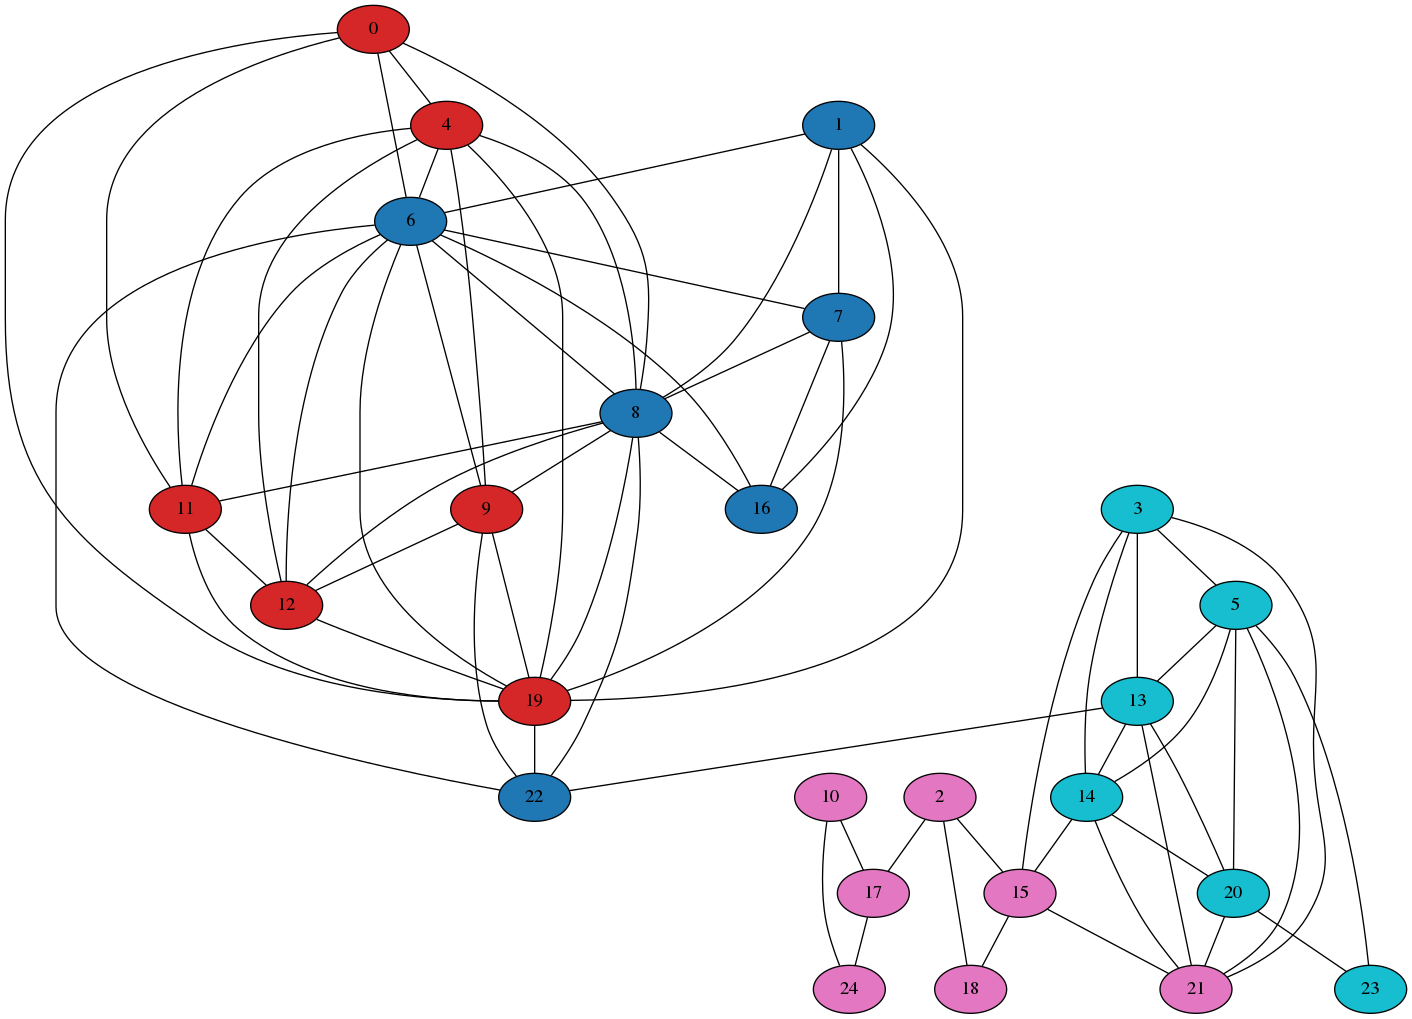

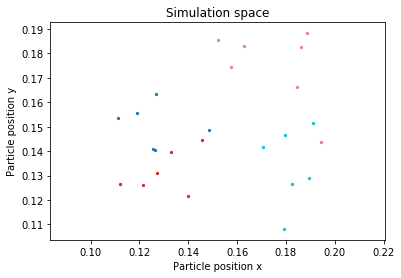

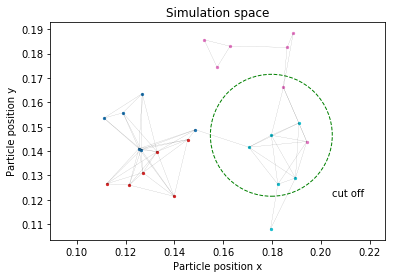

In [53]:
import metis
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib._color_data as mcd
from matplotlib.colors import to_hex 
import matplotlib.patches as mpatch
from random import shuffle
from nxpd import draw

cutoff=2.5*10**-2

normal = lambda p,x :numpy.random.normal(p, x)
uniform= lambda p,x :numpy.random.uniform(p, x)

nbparticles = 25

x = [uniform(0.1, 0.2) for _ in range(nbparticles)]
y = [uniform(0.1, 0.2) for _ in range(nbparticles)]

g = points_to_graph(x, y, cutoff)

nbPE = 4

(edgecuts, parts) = metis.part_graph(g, nbPE)

overlap = {name for name in mcd.CSS4_COLORS if "xkcd:" + name in mcd.XKCD_COLORS}
colors = get_cmap(nb_part, 'tab10') #['red','blue','green']

ncolors = {}
for i, p in enumerate(parts):
    ncolors[i] = colors(p)
    g.node[i]['style'] = 'filled'
    g.node[i]['fillcolor'] = to_hex(colors(p))
    
plot_particles(x, y, colors=ncolors, interaction=False, cutoff=False, save=True, name="images/example_graph_part_metis_colored_without_interactions.pdf")
plot_particles(x, y, colors=ncolors, interaction=True,  cutoff=True, save=True, name="images/example_graph_part_metis_colored_with_interactions.pdf")

backup(dbx, "images/example_graph_part_metis_colored_without_interactions.pdf")
backup(dbx, "images/example_graph_part_metis_colored_with_interactions.pdf")

v = nx.drawing.nx_pydot.write_dot(g, 'images/metis-graph-partitioning.dot') # Requires pydot or pygraphviz
draw(g, show='ipynb')
